Note: you may need to restart the kernel to use updated packages.


In [4]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from cleanvision import Imagelab
from matplotlib import ticker
from PIL import Image
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader


# For reproducability
SEED = 51432

# Set a random seed for PyTorch
torch.manual_seed(SEED)

# Enable deterministic behavior for CuDNN (if using CUDA)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

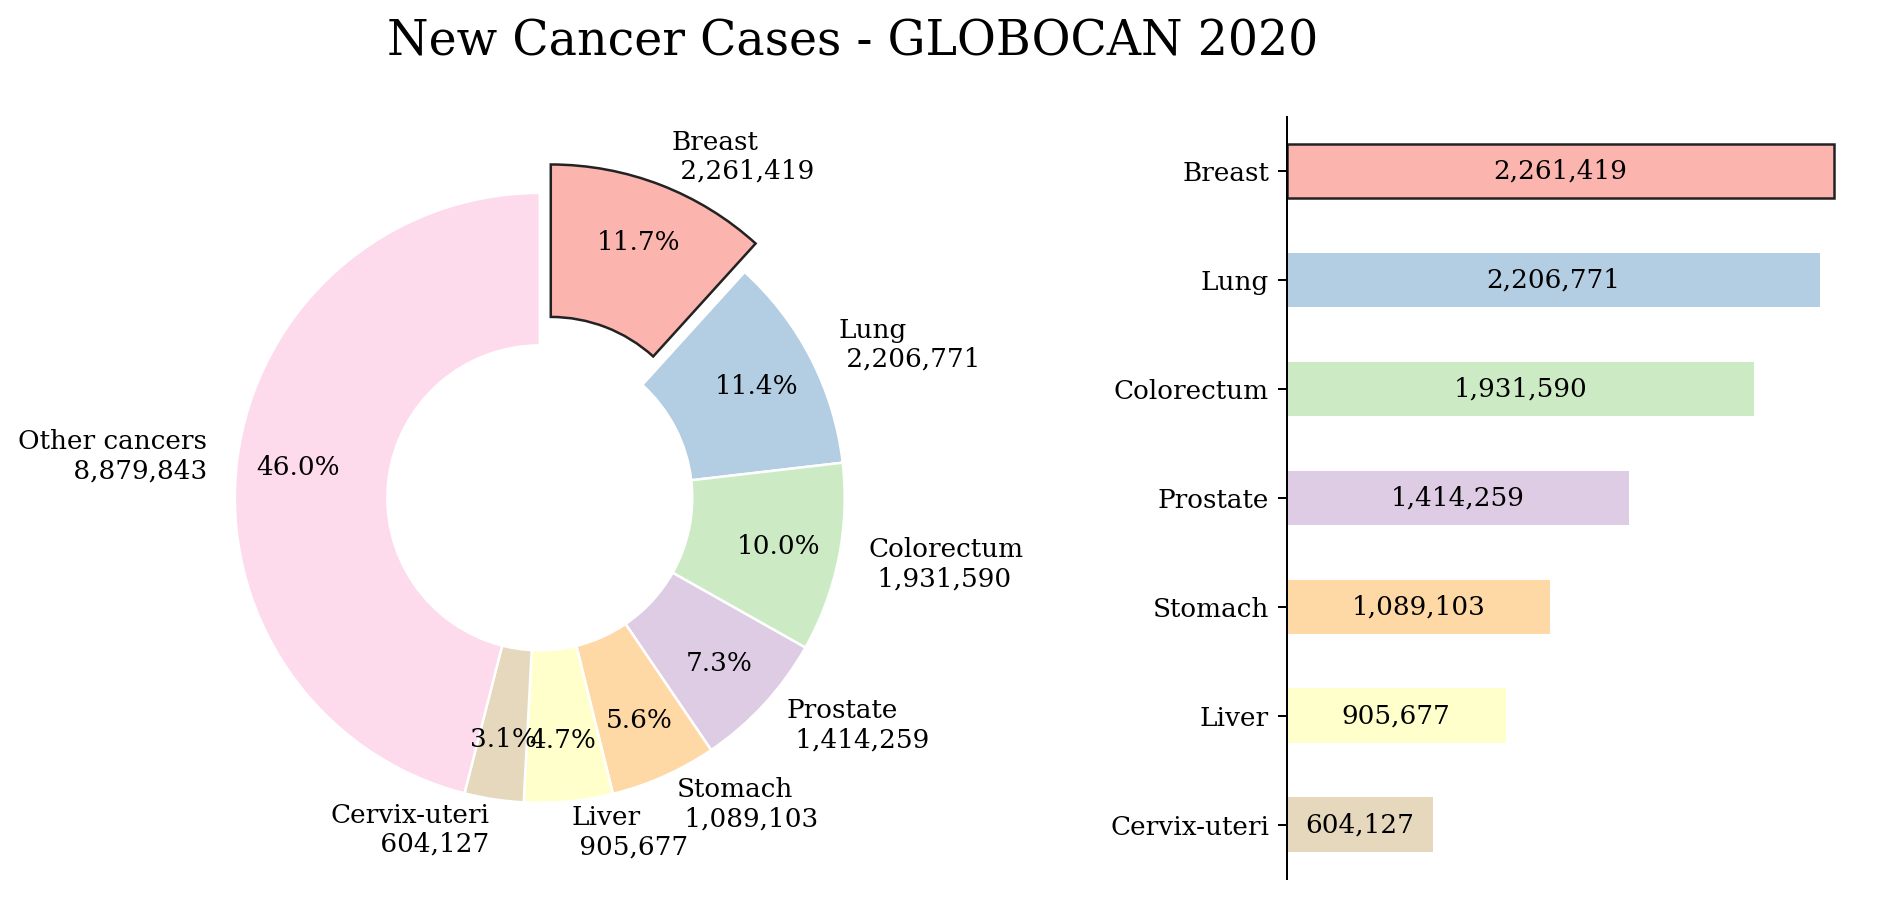

In [4]:
cancer_data = pd.Series({
    "Breast": 2261419,
    "Lung": 2206771,
    "Colorectum": 1931590,
    "Prostate": 1414259,
    "Stomach": 1089103,
    "Liver": 905677,
    "Cervix-uteri": 604127,
    "Other cancers": 8879843
})

fig, axes = plt.subplot_mosaic("aab", figsize=(14, 5.5), dpi=180)
fig.suptitle("New Cancer Cases - GLOBOCAN 2020", size=19, weight=500)
pie_chart = cancer_data.plot.pie(colors=plt.colormaps["Pastel1"].colors, startangle=90,
                                 autopct=lambda x: f"{x:.1f}%", pctdistance=0.8,
                                 explode=[0.1] + [0]*7, counterclock=False,
                                 ax=axes["a"], wedgeprops=dict(width=0.5, edgecolor='w'),
                                 labels=[f"{kind}\n {count:,}" 
                                         for kind, count in cancer_data.items()])
axes["a"].axis("off")

cancer_data_specific = cancer_data.drop("Other cancers").sort_values()
bar_chart = cancer_data_specific.plot.barh(ax=axes["b"],
                                           color=plt.colormaps["Pastel1"].colors[-3:: -1])
bar_chart.bar_label(bar_chart.containers[0], [f"{x:,}" for x in cancer_data_specific],
             label_type="center"
)
axes["b"].spines["bottom"].set_visible(False)
axes["a"].patches[0].set_edgecolor("#222")
axes["b"].patches[-1].set_edgecolor("#222")
axes["b"].xaxis.set_visible(False);

In [8]:
fold_info = pd.read_csv("/Users/adu/Downloads/BreaKHis_v1/BreaKHis_v1/Folds.csv")
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head()

fold  mag    grp                                           filename   label
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...  benign

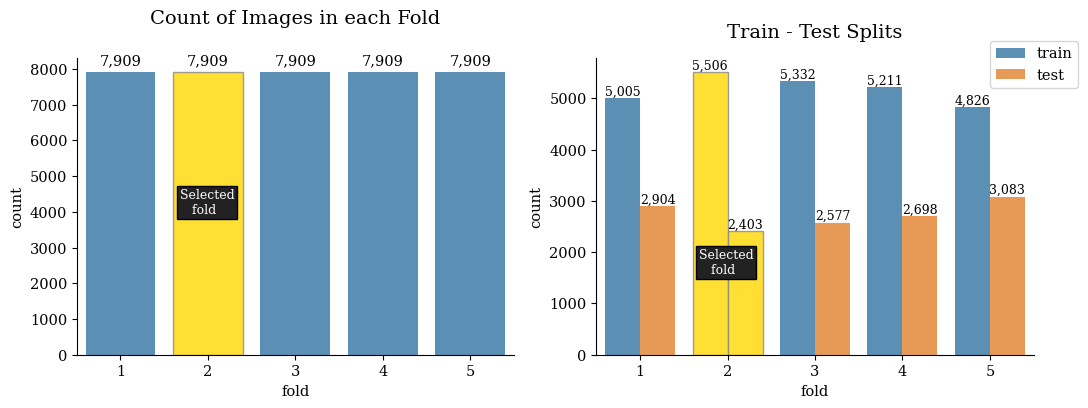

In [9]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy().reset_index(drop=True)

selected_fold_data["filename"] = ("/Users/adu/Downloads/BreaKHis_v1/") + selected_fold_data["filename"]

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize= (11,4.2),tight_layout = True)

sb.countplot(data=fold_info, x="fold", color = "C0", ax= ax1, alpha = 0.8)
bars = ax1.containers[0]
ax1.bar_label(bars,padding=3,labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("gold")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.08, _selected_bar.get_height() / 2,
         "Selected\n   fold", size=9, color="#fff",
         bbox={"pad": 2, "facecolor": "#222"})
ax1.set_title("Count of Images in each Fold", size=14, pad=25)

# Plot train-test split
sb.countplot(data=fold_info, x="fold", hue="grp", palette="tab10",
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("gold")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.07, _selected_bar.get_height() / 5,
         "Selected\n   fold", size=9, color="#fff",
         bbox={"pad": 2, "facecolor": "#222"})
ax2.set_title("Train - Test Splits", size=14, pad=15)
ax2.legend(loc=(0.9, 0.9));

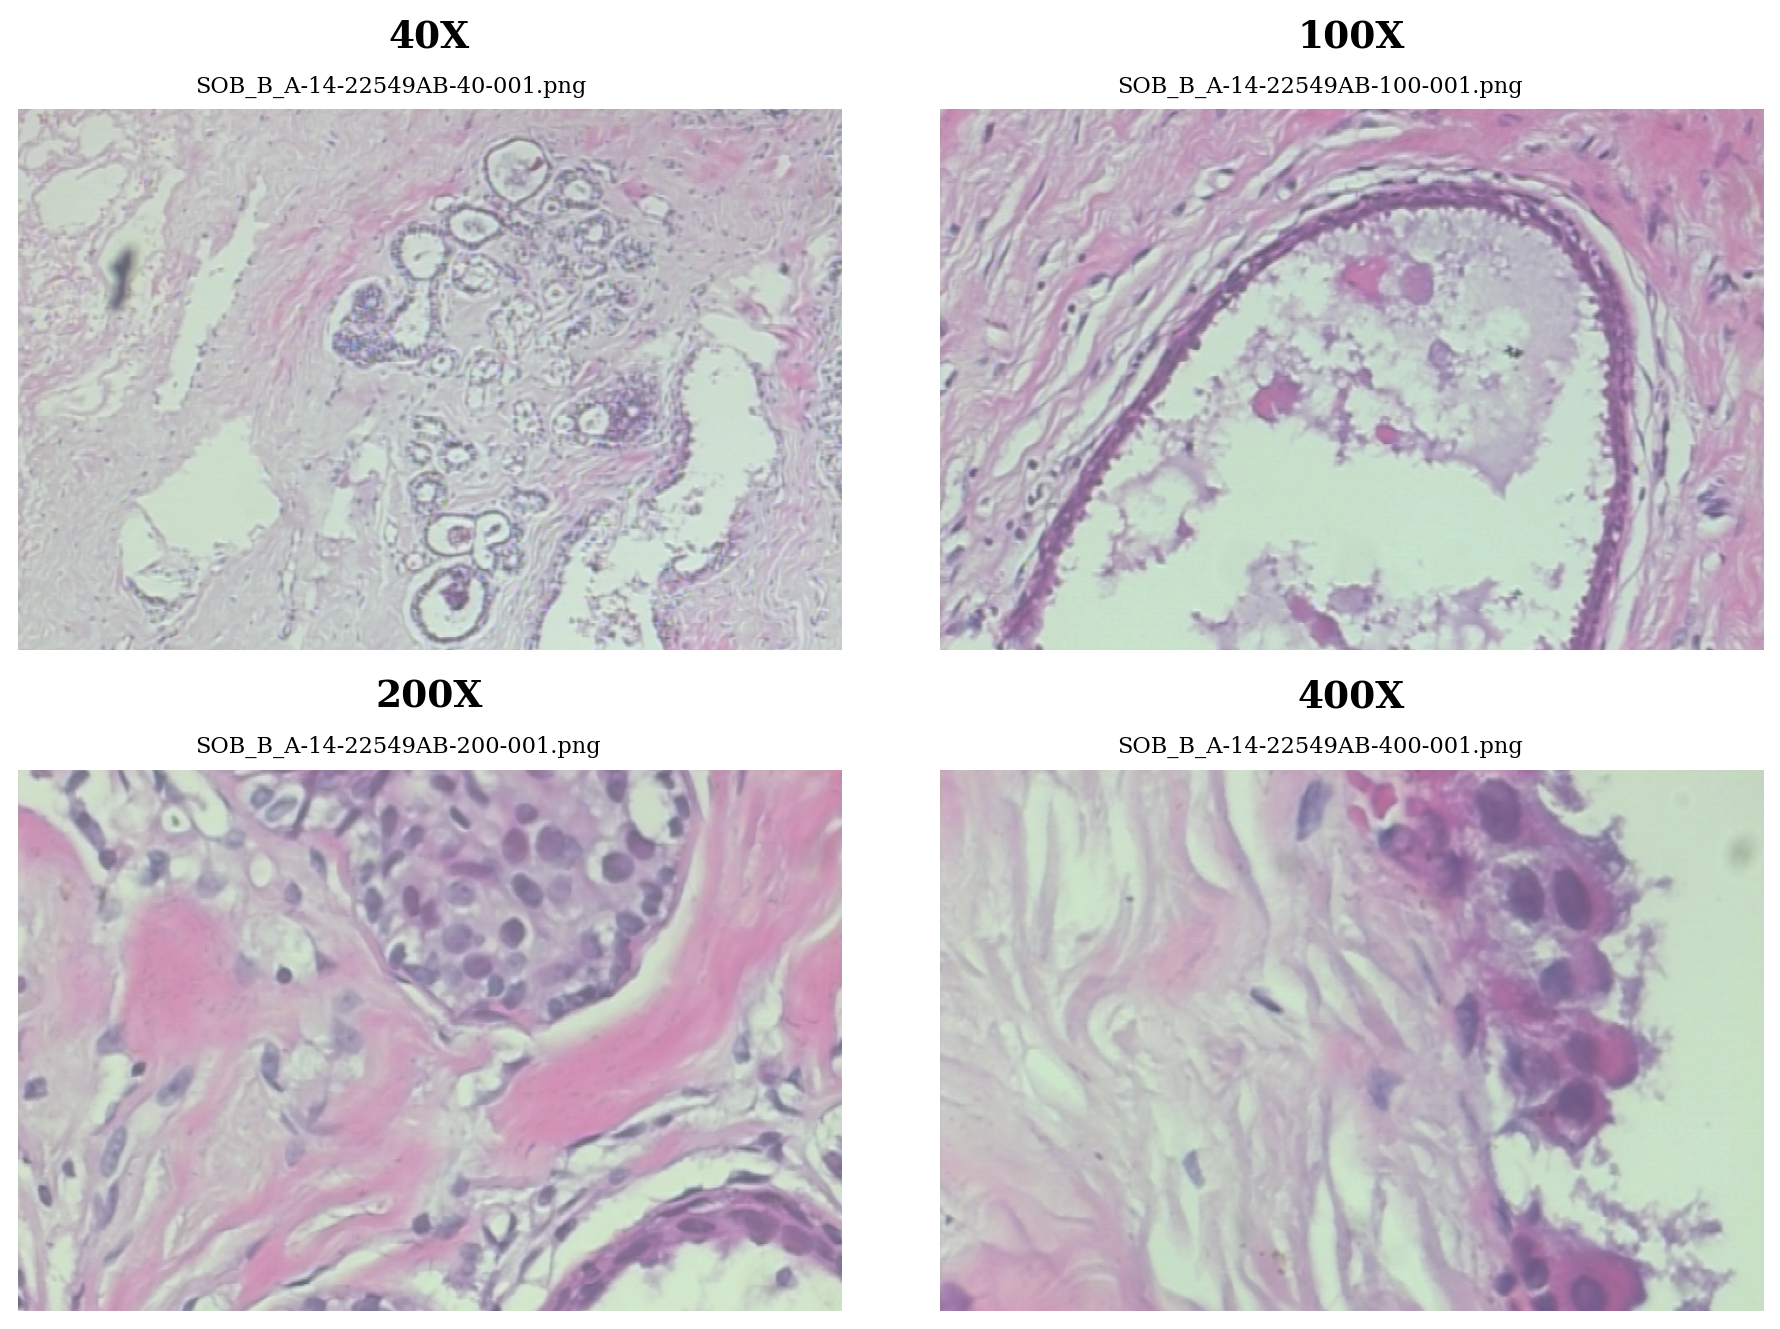

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7.5), dpi=180, tight_layout=True)
sample_images = selected_fold_data.groupby("mag", as_index=False).first()
for ax, row in zip(axes.flat, sample_images.itertuples()):
    img = Image.open(row.filename)
    ax.imshow(img)
    ax.set_title(f"{row.mag}X", size=15, pad=25, weight=600)
    ax.text(150, -15, row.filename.split("/")[-1], size=9)
    ax.axis("off")

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7909 [00:00<?, ?it/s]

  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 256 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | near_duplicates  |            6 |
|  2 | blurry           |            0 |
|  3 | dark             |            0 |
|  4 | grayscale        |            0 |
|  5 | light            |            0 |
|  6 | low_information  |            0 |
|  7 | odd_aspect_ratio |            0 |
|  8 | odd_size         |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


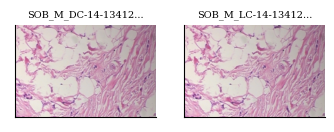

Set: 1


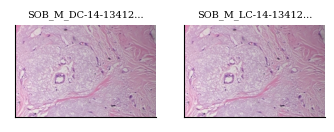

Set: 2


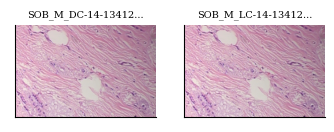

Set: 3


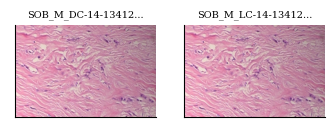

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


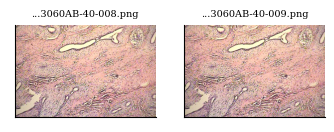

Set: 1


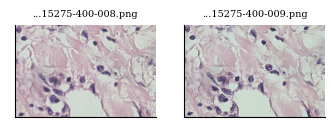

Set: 2


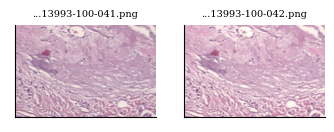

In [11]:
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

In [12]:
duplicated_images = imagelab.issues[
    ["is_exact_duplicates_issue", "is_near_duplicates_issue"]
].any(axis=1).reset_index().rename(columns={"index": "filename", 0: "duplicated"})
duplicated_images.head()

filename  duplicated
0  /Users/adu/Downloads/BreaKHis_v1/BreaKHis_v1/h...       False
1  /Users/adu/Downloads/BreaKHis_v1/BreaKHis_v1/h...       False
2  /Users/adu/Downloads/BreaKHis_v1/BreaKHis_v1/h...       False
3  /Users/adu/Downloads/BreaKHis_v1/BreaKHis_v1/h...       False
4  /Users/adu/Downloads/BreaKHis_v1/BreaKHis_v1/h...       False

In [13]:
assert duplicated_images["filename"].equals(selected_fold_data["filename"])

# Drop all duplicated images, then validate again 
selected_fold_data = selected_fold_data[~duplicated_images["duplicated"]]
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/7653 [00:00<?, ?it/s]

  0%|          | 0/7653 [00:00<?, ?it/s]

Issue checks completed. 0 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


In [10]:
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")
train.shape, test.shape

((2682, 5), (1151, 5))

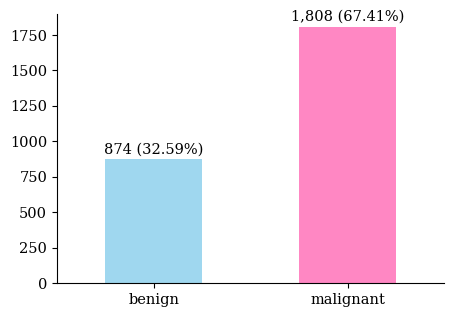

In [16]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["skyblue", "hotpink"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

In [16]:
y = train["label"].map(classes)
positive_only_preds = np.ones_like(y)
print(f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2%}",
      f"\nROC-AUC:  {metrics.roc_auc_score(y, positive_only_preds):.2%}")

Accuracy: 65.94% 
ROC-AUC:  50.00%


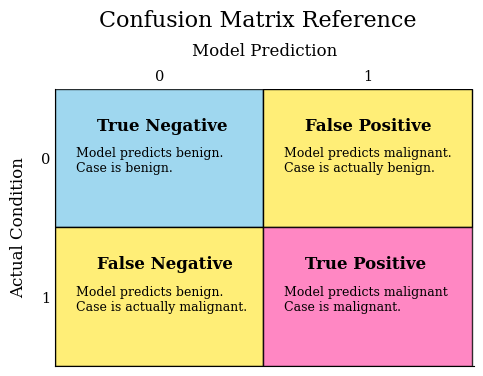

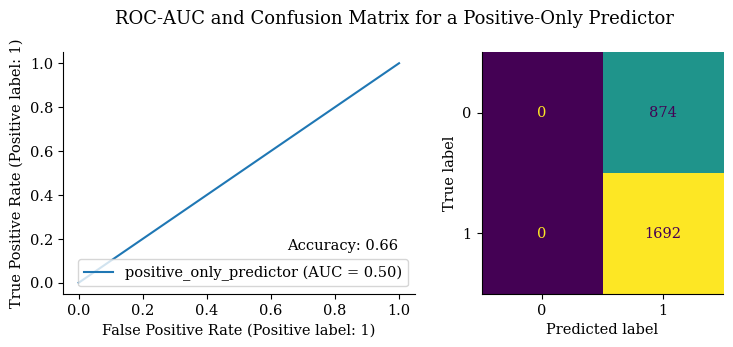

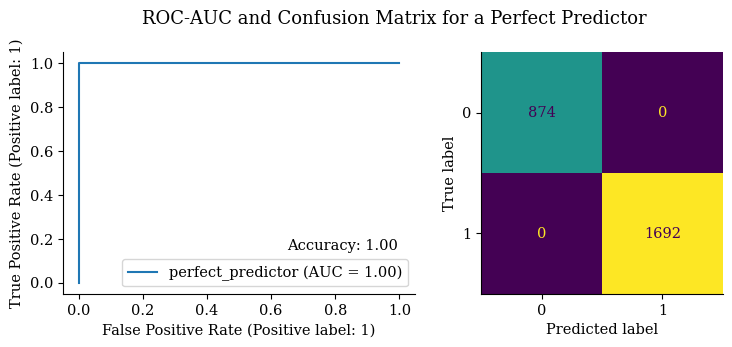

In [17]:
# Draw a confusion matrix with descriptions
fig, ax = plt.subplots(figsize=(5.4, 3.6))
ax.axvspan(0, 0.5, 0.5, 1, facecolor="skyblue", alpha=0.8, edgecolor="black")
ax.axvspan(0.5, 1, 0.5, 1, facecolor="#fe7", edgecolor="black")
ax.axvspan(0, 0.5, 0, 0.5, facecolor="#fe7", edgecolor="black")
ax.axvspan(0.5, 1, 0, 0.5, facecolor="hotpink", alpha=0.8, edgecolor="black")
ax.text(0.1, 0.85, "True Negative", size=12, weight=600)
ax.text(0.05, 0.7, "Model predicts benign.\nCase is benign.", size=9)
ax.text(0.6, 0.85, "False Positive", size=12, weight=600)
ax.text(0.55, 0.7, "Model predicts malignant.\nCase is actually benign.", size=9)
ax.text(0.1, 0.35, "False Negative", size=12, weight=600)
ax.text(0.05, 0.2, "Model predicts benign.\nCase is actually malignant.", size=9)
ax.text(0.6, 0.35, "True Positive", size=12, weight=600)
ax.text(0.55, 0.2, "Model predicts malignant\nCase is malignant.", size=9)
ax.set_xlim(0, 1.005)
ax.xaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.xaxis.set_ticklabels([0, 1])
ax.yaxis.set_major_locator(ticker.FixedLocator([0.25, 0.75]))
ax.yaxis.set_ticklabels([1, 0])
ax.set_ylabel("Actual Condition", size=12, labelpad=10)
ax.set_xlabel("Model Prediction", size=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticks_position("top")
ax.spines["left"].set_position("zero")
ax.tick_params(pad=0, top=False, left=False)
fig.suptitle("Confusion Matrix Reference", y=1.1, size=16)

# Plot metrics for positive-only-predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, positive_only_preds, ax=ax1,
                                         name="positive_only_predictor")
metrics.ConfusionMatrixDisplay.from_predictions(y, positive_only_preds,
                                                ax=ax2, colorbar=False)
ax1.text(0.65, 0.15,
         f"Accuracy: {metrics.accuracy_score(y, positive_only_preds):.2f}")
fig.suptitle("ROC-AUC and Confusion Matrix for a Positive-Only Predictor", size=13)

# Plot metrics for "perfect" predictor
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5), tight_layout=True)
metrics.RocCurveDisplay.from_predictions(y, y, ax=ax1, name="perfect_predictor")
ax1.text(0.65, 0.15, f"Accuracy: {metrics.accuracy_score(y, y):.2f}")
metrics.ConfusionMatrixDisplay.from_predictions(y, y, ax=ax2, colorbar=False)
fig.suptitle("ROC-AUC and Confusion Matrix for a Perfect Predictor", size=13);

In [12]:
from torchvision import transforms

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 28

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_name)
        if self.transform:
            img = self.transform(img)
        return img, label

# Define a transformation to resize and pad images
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])

# Load and preprocess the data
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)

train_data = pd.DataFrame({'filename': X_train, 'label': y_train})
valid_data = pd.DataFrame({'filename': X_valid, 'label': y_valid})

train_dataset = CustomDataset(train_data, transform=transform)
valid_dataset = CustomDataset(valid_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# Prepare the test dataset



NameError: name 'classes' is not defined

In [17]:
test = test.sample(frac=1, random_state=SEED)  # shuffle test data
test_data = pd.DataFrame({'filename': test["filename"], 'label': test["label"].map(classes)})
test_dataset = CustomDataset(test_data, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

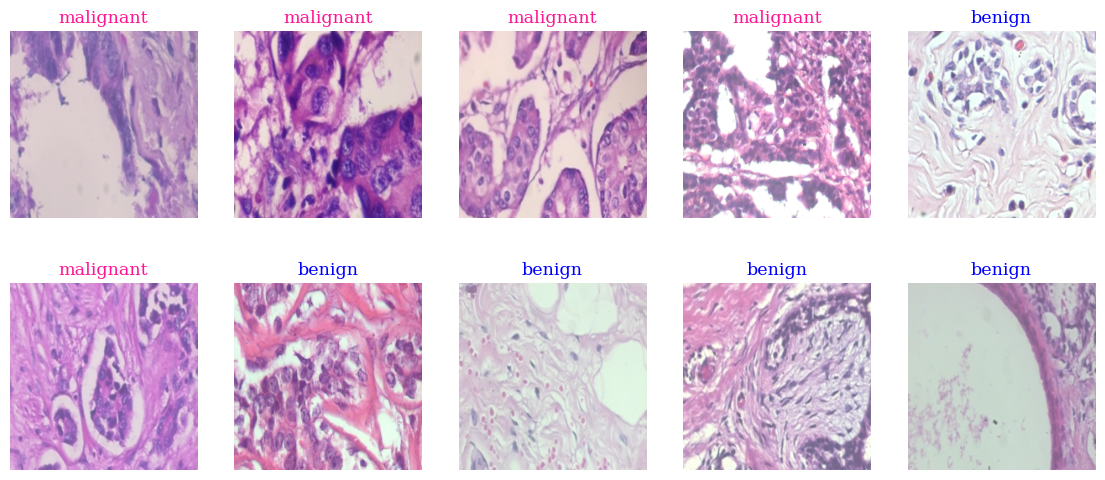

In [33]:
plt.figure(figsize=(14, 6))
for batch in train_loader:
    images, labels = batch

    # Convert labels to numpy
    labels = labels.numpy()

    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        
        image = images[i].numpy().transpose((1, 2, 0))  # Channels-last format
        # plt.imshow(image.astype('uint8'))
        plt.imshow(image)
        label = class_names[labels[i]]
        title_color = "blue" if label == "benign" else "deeppink"
        plt.title(class_names[labels[i]], color=title_color)
        plt.axis("off")

    break  # Break after the first batch for a single iteration


In [49]:
# model  = nn.Sequential(
#     nn.BatchNorm2d(3),
#     nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=3),
#     nn.LeakyReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
#     nn.LeakyReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3),
#     nn.LeakyReLU(),
#     nn.MaxPool2d(2),
#     nn.Dropout(p=0.3),
#     nn.Linear(128,256),
#     nn.LeakyReLU(),
#     nn.Linear(256,32),
#     nn.LeakyReLU(),
#     nn.Dropout(p=0.2),
#     nn.Linear(32,1),
#     nn.Sigmoid(),
# )

# model

Sequential(
  (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (2): LeakyReLU(negative_slope=0.01)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): LeakyReLU(negative_slope=0.01)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (8): LeakyReLU(negative_slope=0.01)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Dropout(p=0.3, inplace=False)
  (11): Linear(in_features=128, out_features=256, bias=True)
  (12): LeakyReLU(negative_slope=0.01)
  (13): Linear(in_features=256, out_features=32, bias=True)
  (14): LeakyReLU(negative_slope=0.01)
  (15): Dropout(p=0.2, inplace=False)
  (16): Linear(in_features=32, out_features=1, bias=True)
  (17): Sigmoid()
)

In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Convolutional block I
        self.batch_norm1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)

        # Convolutional block II
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)

        # Convolutional block III
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2)

        # Fully connected layers
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # Convolutional block I
        x = self.batch_norm1(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Convolutional block II
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Convolutional block III
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # Fully connected layers
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

# Create an instance of the CustomCNN model
model = CustomCNN()


In [66]:
loss_fn = torch.nn.BCELoss()

optimizer= torch.optim.Adam(model.parameters(), lr=0.001)

In [71]:
def train_one_epoch():
    running_loss = 0
    last_loss = 0
    for i, data in enumerate(train_loader):

            input,label = data
            optimizer.zero_grad()
            label = label.float()
            output = model(input).squeeze().float()

            loss = loss_fn(output,label)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 1000 == 999:
                last_loss = running_loss / 1000 # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                # tb_x = epoch_index * len(training_loader) + i + 1
                # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.

    return last_loss

In [75]:
EPOCHS = 25

epoch_number = 0
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)

    avg_loss = train_one_epoch()

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            vlabels = vlabels.float()
            voutputs = model(vinputs).squeeze().float()
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}'.format(epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

    



EPOCH 1:
LOSS train 0 valid 0.3405238091945648
EPOCH 2:
LOSS train 0 valid 0.31375226378440857
EPOCH 3:
LOSS train 0 valid 0.25373604893684387
EPOCH 4:
LOSS train 0 valid 0.2709420919418335
EPOCH 5:
LOSS train 0 valid 0.24067747592926025
EPOCH 6:
LOSS train 0 valid 0.2527957260608673
EPOCH 7:
LOSS train 0 valid 0.20539967715740204
EPOCH 8:
LOSS train 0 valid 0.22070756554603577
EPOCH 9:
LOSS train 0 valid 0.2240474969148636
EPOCH 10:
LOSS train 0 valid 0.21351972222328186
EPOCH 11:
LOSS train 0 valid 0.2223706692457199
EPOCH 12:
LOSS train 0 valid 0.21835501492023468
EPOCH 13:
LOSS train 0 valid 0.20029973983764648
EPOCH 14:
LOSS train 0 valid 0.20553754270076752
EPOCH 15:
LOSS train 0 valid 0.19828854501247406
EPOCH 16:
LOSS train 0 valid 0.21567748486995697
EPOCH 17:
LOSS train 0 valid 0.2032455950975418
EPOCH 18:
LOSS train 0 valid 0.25889331102371216
EPOCH 19:
LOSS train 0 valid 0.18912336230278015
EPOCH 20:
LOSS train 0 valid 0.18326647579669952
EPOCH 21:
LOSS train 0 valid 0.2162

LOAD MODEL


In [2]:
from torchmetrics.classification import BinaryAccuracy

In [3]:
metric  = BinaryAccuracy()

In [18]:
test_model = CustomCNN()
test_model_chckpt = torch.load("model_23")
test_model.load_state_dict(test_model_chckpt)
with torch.no_grad():
        acc = 0
        ts = 0
        for j, tdata in enumerate(test_loader):
            tinputs, tlabels = tdata
            tlabels = tlabels.float()
            toutputs = test_model(tinputs).squeeze().float()
            print(toutputs.shape)

            acc += metric(toutputs,tlabels)
            print(acc)


acc = acc / (j+1)

print(f"Accuracy : {acc} ")

torch.Size([28])
tensor(0.7500)
torch.Size([28])
tensor(1.6429)
torch.Size([28])
tensor(2.2857)
torch.Size([28])
tensor(2.9643)
torch.Size([28])
tensor(3.8571)
torch.Size([28])
tensor(4.6429)
torch.Size([28])
tensor(5.4643)
torch.Size([28])
tensor(6.3214)
torch.Size([28])
tensor(7.1071)
torch.Size([28])
tensor(7.9286)
torch.Size([28])
tensor(8.8214)
torch.Size([28])
tensor(9.5714)
torch.Size([28])
tensor(10.3214)
torch.Size([28])
tensor(11.1071)
torch.Size([28])
tensor(11.8214)
torch.Size([28])
tensor(12.5357)
torch.Size([28])
tensor(13.3571)
torch.Size([28])
tensor(14.1786)
torch.Size([28])
tensor(15.0357)
torch.Size([28])
tensor(15.8571)
torch.Size([28])
tensor(16.6429)
torch.Size([28])
tensor(17.3929)
torch.Size([28])
tensor(18.1071)
torch.Size([28])
tensor(18.7143)
torch.Size([28])
tensor(19.5357)
torch.Size([28])
tensor(20.2857)
torch.Size([28])
tensor(21.0714)
torch.Size([28])
tensor(21.8929)
torch.Size([28])
tensor(22.6071)
torch.Size([28])
tensor(23.3571)
torch.Size([28])
tenso

In [21]:
len(test_dataset)

1151